In [5]:
import pickle
import lzma

with lzma.open('movie_data_movielens.xz', 'rb') as f:
    train_movie_ratings_list, test_movie_ratings_list = pickle.load(f)

In [1]:
import pickle
import lzma

with lzma.open('params_with_f_k=10_2024-05-15 08:15:55.448059.xz', 'rb') as f:
    params = pickle.load(f)

locals().update(params)

In [6]:
movie_ratings_list = [a+b for a, b in zip(train_movie_ratings_list, test_movie_ratings_list)]
del train_movie_ratings_list, test_movie_ratings_list

In [2]:
with lzma.open('movies_map.xz', 'rb') as f:
    title_to_id_moviesmap, id_to_title_moviesmap, id_to_genres_moviesmap = pickle.load(f)

In [3]:
with lzma.open('general_movielens.xz', 'rb') as f:
    userid_to_index, index_to_userid, movieid_to_index, index_to_movieid = pickle.load(f)

In [7]:
import numpy as np
unpopular_movies = []
# movie_indices = []
for index, movie in enumerate(movie_ratings_list):
    if len(movie) < 50:
        unpopular_movies.append(index)
unpopular_movies = np.array(unpopular_movies)

In [8]:
all_genres = ['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'IMAX',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'Film-Noir']

def parser(val):
  init = np.zeros(len(all_genres), dtype=int)
  val_list = val.split('|')
  if val_list[0] != '(no genres listed)':
    indices = [all_genres.index(v) for v in val_list]
    init[indices] = 1
  return init

In [9]:
import numpy as np

def train_new_user_unk(movies_list, iter=400):
    unk = len(movies_list)
    U = np.zeros((k))
    V = np.zeros((unk, k))
    item_biases = np.zeros((unk))
    user_bias = 0
    jitter = 1e-20
    ratings = np.array([r for (_, r) in movies_list]) 
    feature_vector = np.array([parser(f) for (f, _) in movies_list])
    for _ in range(iter):
        # movies_array = np.array(movies_list) 
        user_bias = lmb * np.sum(ratings - np.einsum('i,ji->j', U, V) - item_biases) / (lmb * unk + gamma)
    
        left = np.sum(np.einsum('ij,il->ijl', V, V), axis=0)
        right = np.sum(np.einsum('ji,j->ji', V, ratings - user_bias - item_biases), axis=0)
    
        U = np.linalg.solve(lmb * left + tau * np.eye(k), lmb * right)

        for n in range(unk):
            # Calculate item bias
            item_bias = lmb * np.sum(ratings - np.einsum('ij,j->i', U[None, :], V[n]) - user_bias) / (lmb * unk + gamma)
            item_biases[n] = item_bias
            # Calculate left and right matrices for item factor update
            left = np.sum(np.einsum('ij,il->ijl', U[None, :], U[None, :]), axis=0)
            right = np.sum(np.einsum('ji,i->ji', U[None, :], ratings - user_bias - item_bias), axis=0)
        
            total_right = lmb * right + tau * 1/np.sqrt(np.sum(feature_vector[n])+jitter) * np.einsum('i, ij -> j', feature_vector[n], F)
            V[n] = np.linalg.solve(lmb * left + tau * np.eye(k), total_right)
    return U, V

In [12]:
def get_valid_movies(movie_indices, n):
    valid_movies = []
    for movie in movie_indices:
        if movie not in unpopular_movies:
            valid_movies.append(movie)
    return valid_movies[:n]

In [13]:
import numpy as np

def train_new_user(movies_list, iter=400):
    U = np.zeros((k))

    for _ in range(iter):
        movies_array = np.array(movies_list)
        ratings = movies_array[:, 1]
        indices = movies_array[:, 0].astype(int)
        user_bias = lmb * np.sum(ratings - np.einsum('i,ji->j', U, V[indices]) - item_biases[indices]) / (lmb * len(indices) + gamma)
    
        left = np.sum(np.einsum('ij,il->ijl', V[indices], V[indices]), axis=0)
        right = np.sum(np.einsum('ji,j->ji', V[indices], ratings - user_bias - item_biases[indices]), axis=0)
    
        U = np.linalg.solve(lmb * left + tau * np.eye(k), lmb * right)
        # print(U, user_bias)
    return U
    
def predict(movies_list, n=10, threshold=0.1):
    movie_ids = []
    U = train_new_user(movies_list)
    movie_indices = np.argsort(np.einsum('i,ji->j', U, V) + threshold*item_biases)[::-1]
    predictions = get_valid_movies(movie_indices, n)
    # predictions = movie_indices[:n]
    for i, indices in enumerate(predictions):
        movie_id = index_to_movieid[indices]
        movie_ids.append(movie_id)
        print(f'{i+1}:{id_to_title_moviesmap[movie_id]}')
    # return movie_ids

In [32]:
id_to_genres_moviesmap[2133]

'Adventure|Comedy'

In [68]:
def predict_unk(movies_list, n=10, threshold=0.1, iter=400):
    movie_ids = []
    U, movie_embeddings = train_new_user_unk(movies_list, iter)
    movie_indices = np.argsort(np.einsum('i,ji->j', U, V) + threshold*item_biases)[::-1]
    predictions = get_valid_movies(movie_indices, n)
    # predictions = movie_indices[:n]
    for i, indices in enumerate(predictions):
        movie_id = index_to_movieid[indices]
        movie_ids.append(movie_id)
        print(f'{i+1} : {id_to_title_moviesmap[movie_id]} : {id_to_genres_moviesmap[movie_id]}')
    # return movie_ids
    return movie_embeddings

In [69]:
import re
def check(val, movies):
  matched = []
  for movie in movies:
    if re.search(val, movie.lower()):
      matched.append(movie)
  return matched

In [70]:
def get_possible_movie_indices(search_movie, movies_map):
  possible_movies = movies_map.keys()
  for val in search_movie.split():
    possible_movies = check(val, possible_movies)

  for possible_movie in possible_movies:
    try:
        print(f'{movieid_to_index[movies_map[possible_movie]]} : {possible_movie} : {movies_map[possible_movie]}')
    except KeyError:
        continue

In [71]:
get_possible_movie_indices('lord of the rings', title_to_id_moviesmap)

2189 : Lord of the Rings, The (1978) : 2116
202 : Lord of the Rings: The Fellowship of the Ring, The (2001) : 4993
36 : Lord of the Rings: The Two Towers, The (2002) : 5952
227 : Lord of the Rings: The Return of the King, The (2003) : 7153
58405 : The Lord of the G-Strings: The Femaleship of the String (2003) : 182439


In [72]:
a = predict_unk([('Adventure|Animation|Children', 5)], 10, 0.1, 200)

1 : Pooh's Heffalump Movie (2005) : Animation|Children
2 : Return to Never Land (2002) : Adventure|Animation|Children
3 : Wild Thornberrys Movie, The (2002) : Animation|Children|Comedy
4 : Piglet's Big Movie (2003) : Animation|Children
5 : Shrek the Halls (2007) : Adventure|Animation|Comedy|Fantasy
6 : Shrek Forever After (a.k.a. Shrek: The Final Chapter) (2010) : Adventure|Animation|Children|Comedy|Fantasy|IMAX
7 : Winnie the Pooh and Tigger Too (1974) : Animation|Children
8 : Ice Age: A Mammoth Christmas (2011) : Adventure|Animation|Children
9 : Ice Age: Dawn of the Dinosaurs (2009) : Action|Adventure|Animation|Children|Comedy|Romance
10 : Tinker Bell and the Legend of the NeverBeast (2014) : Adventure|Animation|Children


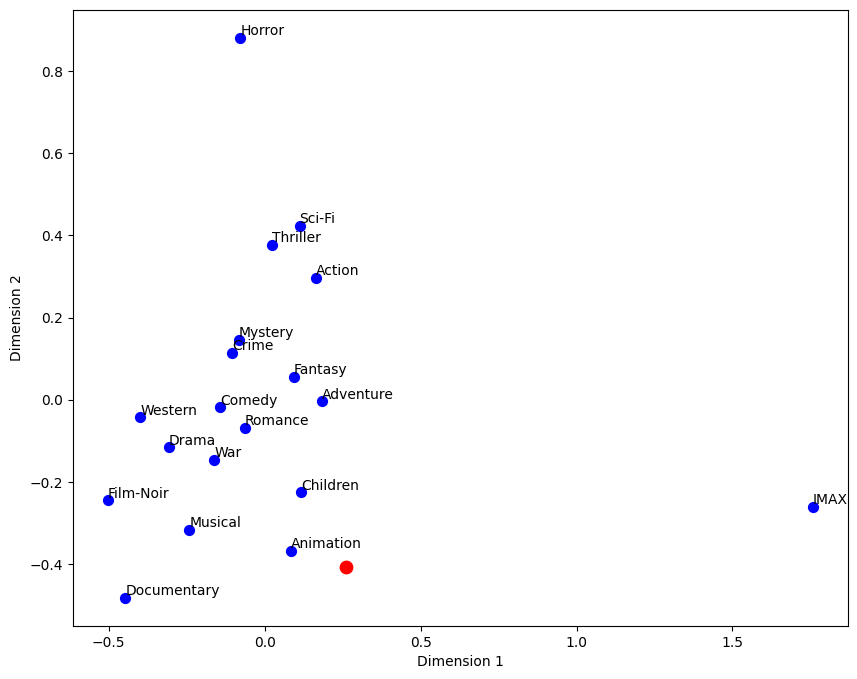

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

b = pca.fit_transform(F)

u = pca.transform(a)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(b[:,0], b[:,1], c='blue', s=50)
ax.scatter(u[:,0], u[:,1], c='red', s=80)
for q, txt in enumerate(all_genres):
    ax.annotate(txt, (b[q,0], b[q,1]), horizontalalignment='left', verticalalignment='bottom')
# ax.annotate('New Movie', (u[:,0], u[:,1]), horizontalalignment='center', verticalalignment='top')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
plt.savefig('coldstart_feature_embedding_plots.pdf', bbox_inches='tight')
# plt.show()

In [205]:
b

array([[ 0.18365875, -0.00422079],
       [ 0.08290038, -0.36793085],
       [ 0.11657782, -0.22598699],
       [-0.14375655, -0.01839246],
       [ 0.09340901,  0.05604122],
       [-0.06355326, -0.0678117 ],
       [-0.30701766, -0.11614658],
       [ 0.16338115,  0.29723354],
       [-0.10471018,  0.11431107],
       [ 0.02341749,  0.37756523],
       [-0.07859573,  0.88165364],
       [-0.08209636,  0.14601885],
       [ 0.11186009,  0.42264394],
       [ 1.75700286, -0.26073782],
       [-0.44750173, -0.48228398],
       [-0.16204076, -0.14726412],
       [-0.24163976, -0.31682906],
       [-0.39882306, -0.04269854],
       [-0.50247249, -0.24516462]])